# Project 2 MI3 Image Classification

### Team LAN: Ashley Kim, Nina Jannatifar, Lauren Markwart

#### Importing TensorFlow + Necessary Libraries

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import PIL

In [2]:
folder = "/Users/ashleykim/Documents/Y4 2022-2023/Spring 2023/DS 4002/Project 2/dataset"

In [22]:
!ls dataset

MildDemented     ModerateDemented NonDemented      VeryMildDemented


#### Removing Corrupted Files

In [23]:
import os

num_skipped = 0
for folder_name in ("MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"):
    folder_path = os.path.join("dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [20]:
data_dir = pathlib.Path(folder)

In [24]:
image_count = len(list(data_dir.glob('*/*.jpg'))) # counting total images in dataset
print(image_count) # 6400

6400


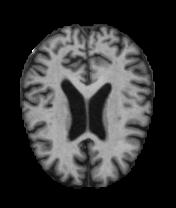

In [25]:
MiD = list(data_dir.glob('MildDemented/*')) # testing by opening random image in Mild Demented folder
PIL.Image.open(str(MiD[0]))

#### Creating training/testing datasets

In [26]:
batch_size = 32
img_height = 180
img_width = 180

In [27]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # splitting 80/20
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [28]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [29]:
class_names = train_ds.class_names 
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


#### Visualizing the data

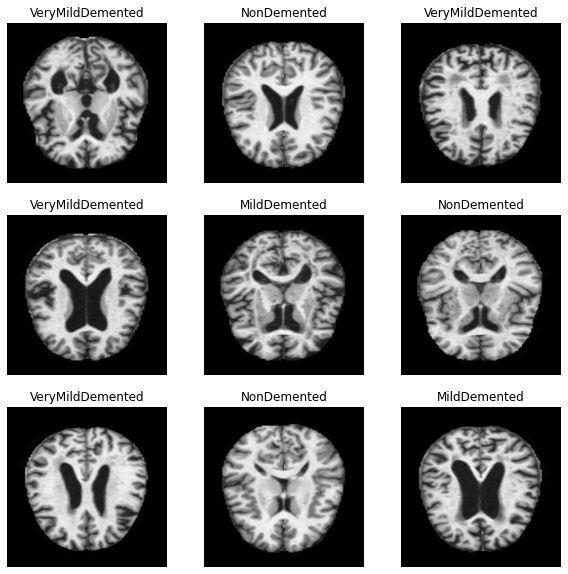

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [31]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### Preparing data for model by standardizing 

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
normalization_layer = layers.Rescaling(1./255)

In [37]:
import numpy as np

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds)) # standardizing RGB values to be in the [0, 1] range 
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.97082794


#### Keras Model

In [40]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [43]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
160/160 [==============================] - 56s 341ms/step - loss: 0.9741 - accuracy: 0.5350 - val_loss: 0.8601 - val_accuracy: 0.6313
Epoch 2/10
160/160 [==============================] - 54s 339ms/step - loss: 0.6701 - accuracy: 0.7086 - val_loss: 0.6596 - val_accuracy: 0.7227
Epoch 3/10
160/160 [==============================] - 55s 342ms/step - loss: 0.3372 - accuracy: 0.8648 - val_loss: 0.2533 - val_accuracy: 0.9055
Epoch 4/10
160/160 [==============================] - 54s 340ms/step - loss: 0.1425 - accuracy: 0.9480 - val_loss: 0.1748 - val_accuracy: 0.9492
Epoch 5/10
160/160 [==============================] - 55s 345ms/step - loss: 0.0562 - accuracy: 0.9820 - val_loss: 0.3036 - val_accuracy: 0.8820
Epoch 6/10
160/160 [==============================] - 54s 340ms/step - loss: 0.0241 - accuracy: 0.9934 - val_loss: 0.0954 - val_accuracy: 0.9727
Epoch 7/10
160/160 [==============================] - 56s 348ms/step - loss: 0.0390 - accuracy: 0.9863 - val_loss: 0.1397 - val_ac

#### Visualizing training model

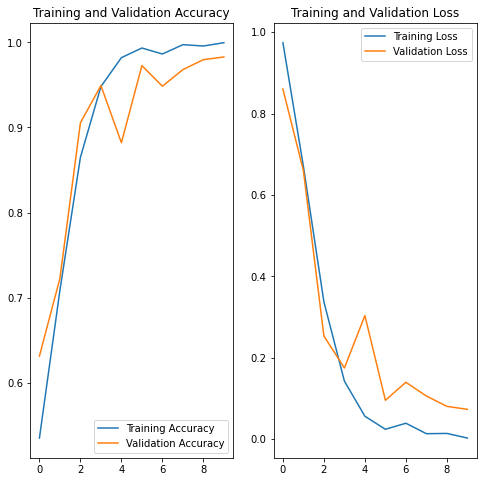

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Using model to predict with new data

In [55]:
test1 = "/Users/ashleykim/Documents/Y4 2022-2023/Spring 2023/DS 4002/Project 2/test1.jpeg" # Moderate Demented
test1_path = pathlib.Path(test1)

img = tf.keras.utils.load_img(
    test1_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to ModerateDemented with a 99.96 percent confidence.


In [56]:
test2 = "/Users/ashleykim/Documents/Y4 2022-2023/Spring 2023/DS 4002/Project 2/test2.jpeg" # Non Demented
test2_path = pathlib.Path(test2)

img = tf.keras.utils.load_img(
    test2_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to NonDemented with a 99.92 percent confidence.


In [57]:
test3 = "/Users/ashleykim/Documents/Y4 2022-2023/Spring 2023/DS 4002/Project 2/test3.jpeg" # Very Mild Demented
test3_path = pathlib.Path(test3)

img = tf.keras.utils.load_img(
    test3_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to VeryMildDemented with a 99.96 percent confidence.
